<a href="https://colab.research.google.com/github/Developer-AD/Yes_Bank_Price_Prediction/blob/main/Yes_Bank_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Import Important Libraries </b>

In [110]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Remove Warnings.
import warnings
warnings.filterwarnings('ignore')

# <b>Exploratory Data Analysis</b>

In [57]:
# Mouting the drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [58]:
# Load csv file as data frame
csv_file_path = '/content/drive/MyDrive/AlmaBetter/CapstoneProject/Yes_Bank_Price_Prediction/data_YesBank_StockPrices.csv'
yes_bank = pd.read_csv(csv_file_path)

In [59]:
# Take quick look at the data structure
yes_bank.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [60]:
# Check shape of the data
yes_bank.shape

(185, 5)

###<b>A quick description of the data like how many non-null values are present in our data, it means we can also find null values from this non-null values, Data type of the feature and Total number of records</b>

In [61]:
# A quick description of the data
yes_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


###<b>As we can see that there is one 'object' data type are present that we need to convert in numerical data types because we can not process object data type to fit in the machine learning model. In machine learning model we can only fit numerical column.</b>

In [62]:
# Check for null values
yes_bank.isnull().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

###<b>We can conclude that there is no null values are present that's good. We can good to go.</b>

In [63]:
# Summary of the Numerical features
yes_bank.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [64]:
# Summary of the Categorical features
yes_bank.describe(include='object')

,Date
count,185
unique,185
top,Jul-05
freq,1


#<b>Visualization of data</b>

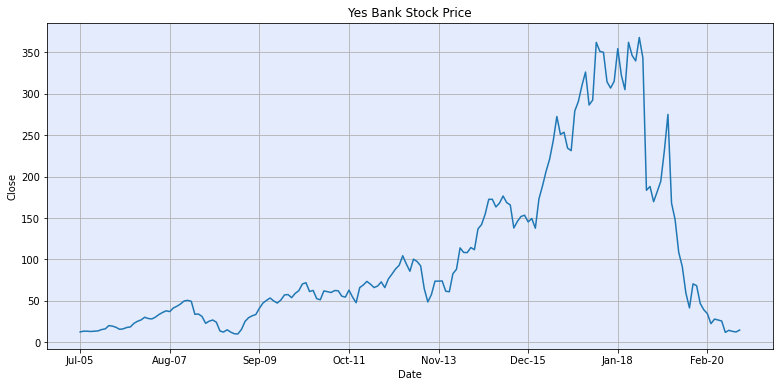

In [65]:
# Visualize the Closing Price
plt.figure(figsize=(13,6))
ax = yes_bank[['Date','Close']]
ax = ax.set_index('Date')
ax['Close'].plot()
plt.axes().set_facecolor("#e3ebfc")
plt.title('Yes Bank Stock Price')
plt.ylabel('Close')
plt.grid()
plt.show()

In [66]:
# List of numeric features for plot the features
numeric_features = yes_bank.describe().columns
numeric_features

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

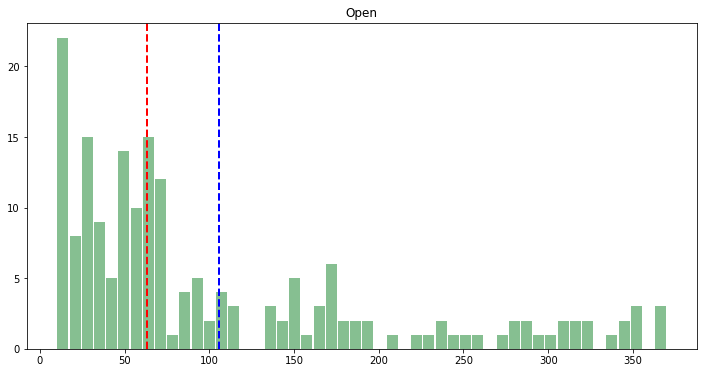

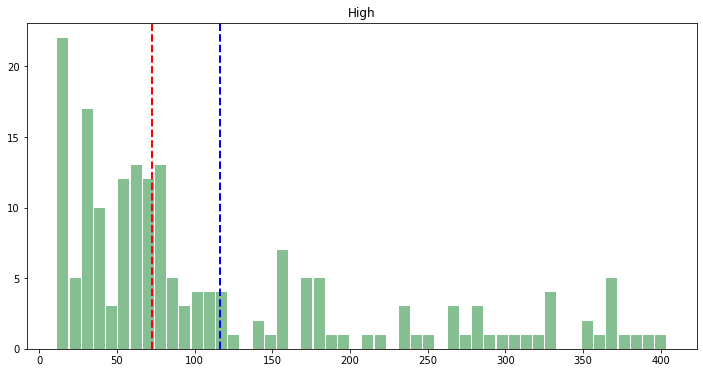

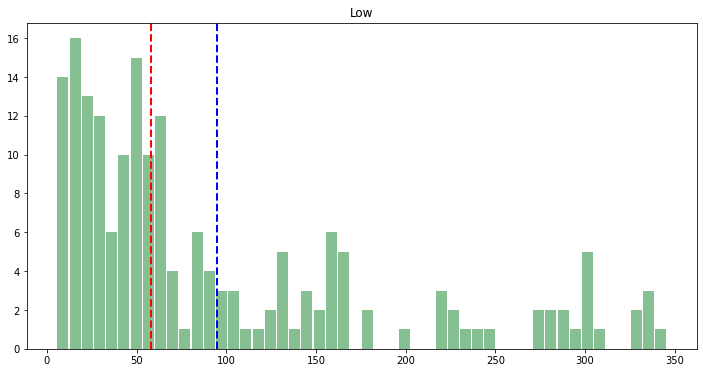

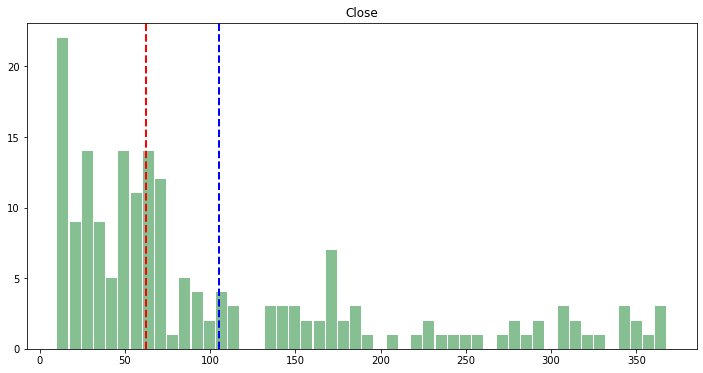

In [67]:
# Plot all features.
# plot a bar plot for each numerical feature count (except Date)

for col in numeric_features:
    fig = plt.figure(figsize=(12, 6))
    ax = fig.gca()
    feature = yes_bank[col]
    feature.hist(bins=50, ax = ax , grid=False, color='#86bf91', zorder=2, rwidth=0.9)
    ax.axvline(feature.mean(), color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='red', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

###<b>Check correlation between all independent and dependent feature</b>

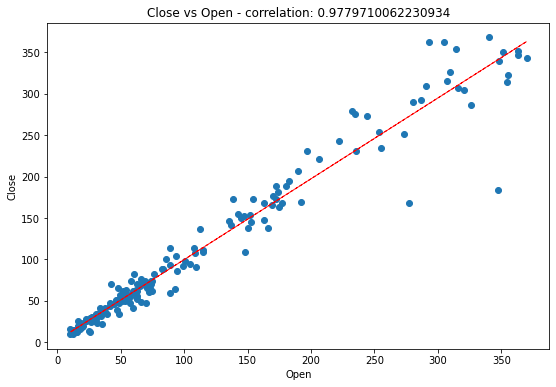

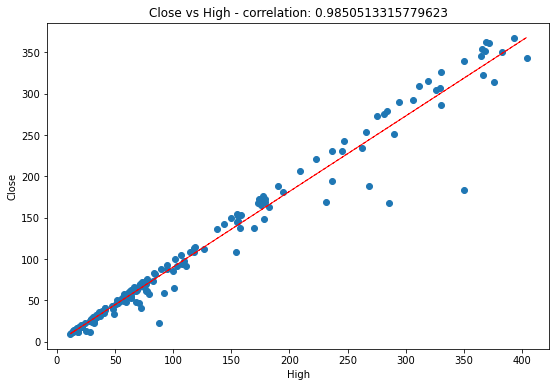

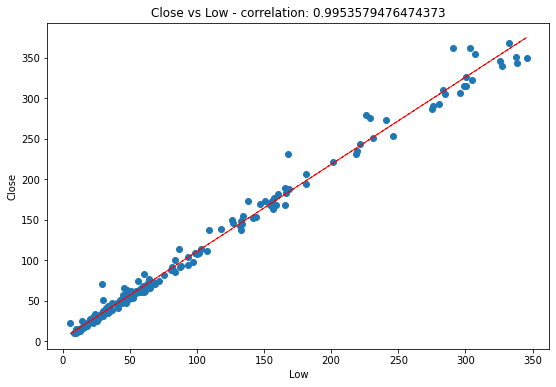

In [68]:
# Removed close for check correlation
for col in numeric_features[:-1]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = yes_bank[col]
    label = yes_bank['Close']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Close')
    ax.set_title('Close vs ' + col + ' - correlation: ' + str(correlation))
    z = np.polyfit(yes_bank[col], yes_bank['Close'], 1)
    y_hat = np.poly1d(z)(yes_bank[col])

    plt.plot(yes_bank[col], y_hat, "r--", lw=1)
plt.show()

###<b> Check Correlation between all features using seaborn Heatmap

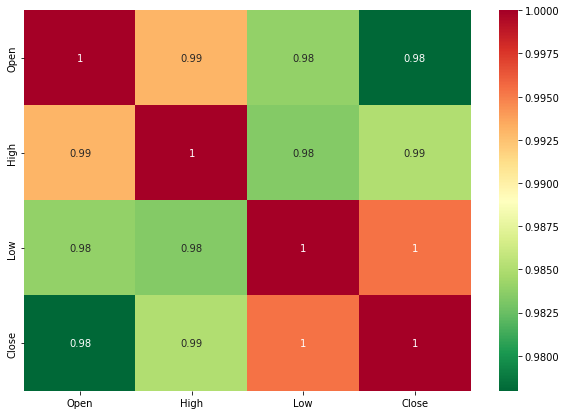

In [69]:
# Plot Correlation headtmap graph using seaborn
plt.figure(figsize=(10,7))
correlation = yes_bank.corr()
sns.heatmap(abs(correlation), annot=True, cmap = 'RdYlGn_r')
plt.show()

In [70]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


In [71]:
calc_vif(yes_bank[[i for i in yes_bank.describe().columns if i not in ['Date','Close']]])

,variables,VIF
0,Open,175.185704
1,High,167.057523
2,Low,71.574137


###<b> Handle Date Feature</b>

In [72]:
# Check data type of 'Date' column
print( yes_bank.Date.dtype )

object


###<b>Here we can see that our Date column is object type from object we can not extract year and month so, we have to convert this object date type to pandas 'datetime64[ns]' so we can apply some functions on it and extract desired year, month, day etc from it</b>

In [73]:
# Convert Date column from object type to pandas datetime64[ns]
yes_bank['Date'] = pd.to_datetime(yes_bank['Date'], format='%b-%y')

In [74]:
# Check change on Date column
yes_bank.head()

,Date,Open,High,Low,Close
0,2005-07-01,13.00,14.00,11.25,12.46
1,2005-08-01,12.58,14.88,12.55,13.42
2,2005-09-01,13.48,14.87,12.27,13.30
3,2005-10-01,13.20,14.47,12.40,12.99
4,2005-11-01,13.35,13.88,12.88,13.41


In [75]:
# Date type of Date column
# Date column changed from boject type to pandas datetime64[ns]
# Now we can apply functions on this column
print(yes_bank.Date.dtype)

datetime64[ns]


In [76]:
# Extract year from Date column
yes_bank['Year'] = yes_bank['Date'].dt.year

In [77]:
# Extract Month from Date column
yes_bank['Month'] = yes_bank['Date'].dt.month

In [78]:
# Check change after new column added
yes_bank.head()

,Date,Open,High,Low,Close,Year,Month
0,2005-07-01,13.00,14.00,11.25,12.46,2005,7
1,2005-08-01,12.58,14.88,12.55,13.42,2005,8
2,2005-09-01,13.48,14.87,12.27,13.30,2005,9
3,2005-10-01,13.20,14.47,12.40,12.99,2005,10
4,2005-11-01,13.35,13.88,12.88,13.41,2005,11


In [79]:
# Now we can drop the Date column
yes_bank.drop(columns = 'Date',inplace=True)

In [80]:
# Check for all column date type
yes_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    185 non-null    float64
 1   High    185 non-null    float64
 2   Low     185 non-null    float64
 3   Close   185 non-null    float64
 4   Year    185 non-null    int64  
 5   Month   185 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 8.8 KB


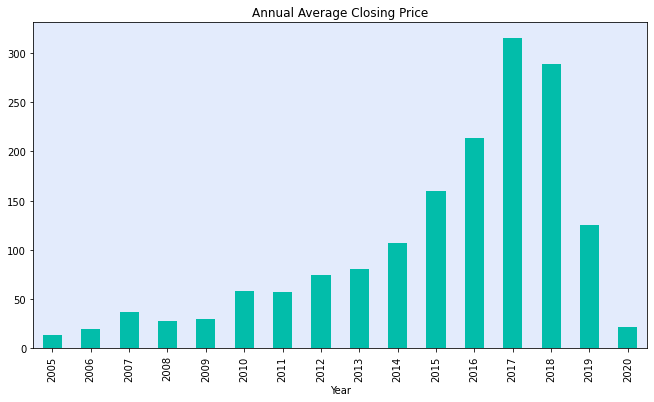

In [81]:
# Annual Average Closing Price.
yes_bank.groupby(['Year'])['Close'].mean().plot(kind='bar', figsize=(11,6), color='#02bdaa' )
plt.axes().set_facecolor("#e3ebfc")
plt.title('Annual Average Closing Price')
plt.show()

###<b> Box Plot visualization</b>

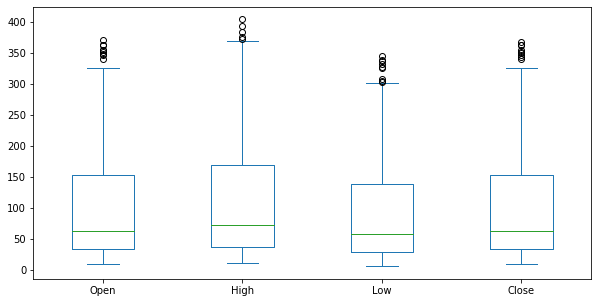

In [82]:
# Check for outliers
yes_bank[['Open', 'High', 'Low', 'Close']].plot(kind='box',figsize=(10,5))
plt.show()

###<b>Now our all feature are numerical and we can move to building our supervied machine learning model.</b>

#<b>Building Machine Learning Model</b>

In [83]:
# Differenciate Independent and Dependent variable
X = yes_bank.drop(columns='Close').values
y = yes_bank['Close'].values

In [84]:
# Check shape of dependent and independent variable
X.shape, y.shape

((185, 5), (185,))

In [85]:
# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

##<b>Rescalling the data</b>

In [86]:
# scale = StandardScaler()
'''Here we use MinMaxScaler but you can use StandardScale also,
   both are giving same accuracy. '''

# Resclalling data : this will rescale in between 0 and 1
scale = MinMaxScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

##<b>Linear Regression Model Trainning.</b>

In [87]:
# creating object of LinearRegression()
regressor = LinearRegression()

# Fitting data into Multiple linear regression
regressor.fit(x_train, y_train)

LinearRegression()

In [88]:
# Y intercept of regressor
regressor.intercept_

10.995140666464891

In [89]:
# Coefficients of regressor
regressor.coef_

array([-154.7127103 ,  177.78608317,  343.27674963,   -0.88664802,
         -4.30510043])

##<b>Checking Performance Of Regression Model</b>

In [90]:
# Do prediction on trainning data
y_pred_train = regressor.predict(x_train)

# Do prediction on test data
y_pred_test = regressor.predict(x_test)

###<b>Training Performance</b>

In [91]:
# Mean Squared Error Of Trainning Data
MSE_train = mean_squared_error(y_train, y_pred_train)
print(f"Mean Squared Error On Trainning Data : {MSE_train}")

# Root Mean Squared Error Of Trainning Data
# MSE**0.5 mean square root of MSE, you can use sqrt() from math module
RMSE_train = MSE_train**0.5 
print(f"Root Mean Squared Error On Trainning Data : {RMSE_train}")


Mean Squared Error On Trainning Data : 39.33625737830814
Root Mean Squared Error On Trainning Data : 6.271862353265427


In [92]:
# Check Accuracy of our on trainning data
# You can also use regressor.score(x_train, y_train) to check accuracy
train_performance = r2_score(y_train, y_pred_train)
print(f'Trainning Accuracy : {train_performance}')

Trainning Accuracy : 0.9956465282860846


###<b>Testing Performance</b>

In [93]:
# Mean Squared Error Of Trainning Data
MSE_test = mean_squared_error(y_test, y_pred_test)
print(f"Mean Squared Error On Testing Data : {MSE_test}")

# Root Mean Squared Error Of Trainning Data
RMSE_test = MSE_test**0.5 
print(f"Root Mean Squared Error On Testing Data : {RMSE_test}")

Mean Squared Error On Testing Data : 80.56653535374932
Root Mean Squared Error On Testing Data : 8.975886326917767


In [94]:
# Check Accuracy of our on test data
test_performance = r2_score(y_test, y_pred_test)
print(f'Testing Accuracy : {test_performance}')

Testing Accuracy : 0.9928422855965229


###<b>Visualize Performance Of Our Linear Regression Model</b>

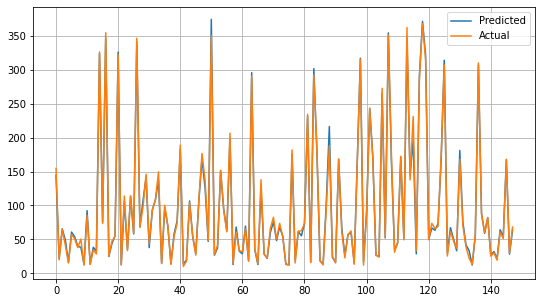

In [95]:
# On Trainning data
plt.figure( figsize=(9,5) )
plt.plot(y_pred_train)
plt.plot( y_train )
plt.grid()
plt.legend(["Predicted","Actual"])
plt.show()

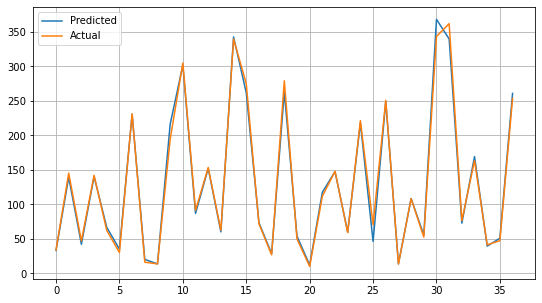

In [96]:
# On Testing data
plt.figure( figsize=(9,5) )
plt.plot(y_pred_test)
plt.plot( y_test )
plt.grid()
plt.legend(["Predicted","Actual"])
plt.show()

##<b>Regulerization On Linear Regression Model</b>

###<b>Ridge Regulerization</b>

In [97]:
# Finding alpha using GridseachCV
# Hyperprarameter tuning
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [98]:
print(ridge_regressor.best_params_)

{'alpha': 0.01}


In [99]:
# Fitting the model with best parameter
ridge_with_best_alpha = Ridge(alpha=0.01)
ridge_with_best_alpha.fit(x_train, y_train)

Ridge(alpha=0.01)

In [100]:
ridge_with_best_alpha.score(x_train, y_train)

0.9955791667807274

###<b>Lasso Regulerization</b>

In [101]:
# Finding alpha using GridseachCV for Lasso Regulerization
# Hyperprarameter tuning
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [102]:
lasso_regressor.best_params_

{'alpha': 1e-08}

In [103]:
# Fitting the model with best parameter
lasso_with_best_alpha = Lasso(alpha=1e-08)
lasso_with_best_alpha.fit(x_train, y_train)

Lasso(alpha=1e-08)

In [104]:
lasso_with_best_alpha.score(x_train, y_train)

0.9956465282860844

###<b>Conclusion : 

##<b>Decision Tree Regression Model</b>

In [105]:
tree_regressor = DecisionTreeRegressor(max_depth=15)
tree_regressor.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=15)

In [106]:
# Decision Tree Regression Accuracy On Trainning Data
tree_regressor.score(x_train, y_train)

1.0

In [107]:
# Decision Tree Regression Accuracy On Trainning Data
tree_regressor.score(x_test, y_test)

0.9802624070453188

###<b>Random Forest<b>

In [111]:
random_reg = RandomForestRegressor()

In [112]:
random_reg.fit(x_train, y_train)

RandomForestRegressor()

In [113]:
# Fit the object to train dataset
random_reg.score(x_train, y_train)

0.9981081958446457

In [121]:
# Hyperparameter tuning

rf = DecisionTreeRegressor() # For GBM, use GradientBoostingClassifier()
grid_values = {'n_estimators':[np.arange(1,100)], 'max_depth':[1,20]}
rf_grid = GridSearchCV(estimator = rf, param_grid = grid_values, scoring = 'roc_auc', cv=5)



In [123]:
# rf_grid.fit(x_train, y_train)